<a href="https://colab.research.google.com/github/Evgeniya371/PRA3024/blob/main/Homework_3_(CNN).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Some data-handling functions to download/import.

# from https://github.com/yandexdataschool/mlhep2018/blob/master/day2-Tue/seminar-03-keras-cnn/seminar_tf_keras.ipynb
"""I load some cifar"""

import numpy as np
from sklearn.model_selection import train_test_split
import os, sys
if sys.version_info[0] == 2:
    from urllib import urlretrieve
    import cPickle as pickle

else:
    from urllib.request import urlretrieve
    import pickle

def unpickle(file):
    fo = open(file, 'rb')
    if sys.version_info[0] == 2:
        dict = pickle.load(fo)
    else:
        dict = pickle.load(fo,encoding='latin1')
    
    fo.close()
    return dict




def download_cifar10(path,
                     url='https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz',
                     tarname='cifar-10-python.tar.gz',):
    import tarfile
    if not os.path.exists(path):
        os.mkdir(path)
    
        

    urlretrieve(url, os.path.join(path,tarname))
    tfile = tarfile.open(os.path.join(path,tarname))
    tfile.extractall(path=path)
    

def load_cifar10(data_path=".",channels_last=False,test_size=0.2,random_state=1337):
    
    test_path = os.path.join(data_path,"cifar-10-batches-py/test_batch")
    train_paths = [os.path.join(data_path,"cifar-10-batches-py/data_batch_%i"%i) for i in range(1,6)]
    
    if not os.path.exists(test_path) or not all(list(map(os.path.exists, train_paths))):
        print ("Dataset not found. Downloading...")
        download_cifar10(data_path)

    train_batches = list(map(unpickle,train_paths))
    test_batch = unpickle(test_path)

    X = np.concatenate([batch["data"] for batch in train_batches]).reshape([-1,3,32,32]).astype('float32')/255
    y = np.concatenate([batch["labels"] for batch in train_batches]).astype('int32')
    X_train,X_val,y_train,y_val = train_test_split(X,y,
                                                   test_size=test_size,
                                                   random_state=random_state)
    
    X_test = test_batch["data"].reshape([-1,3,32,32]).astype('float32')/255
    y_test = np.array(test_batch["labels"]).astype('int32')
    
    if channels_last:
        #convert from [batch,3,H,W] to [batch,H,W,3]
        #WARNING! Make this is only necessary for tensorflow-style dim order
        #If you use theano-style dimensions in keras config, skip this cell
        X_train = X_train.transpose([0,2,3,1])
        X_val   = X_val.transpose([0,2,3,1])
        X_test  = X_test.transpose([0,2,3,1])

    
    return X_train,y_train,X_val,y_val,X_test,y_test

In [ ]:
import tensorflow as tf
#gpu_options = tf.GPUOptions(allow_growth=True, per_process_gpu_memory_fraction=0.1) # restricts GPU load for multi-user nodes

import tensorflow.keras as keras
from keras import backend as K
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
print(tf.__version__)
print(keras.__version__)

2.11.0
2.11.0


In [ ]:
# Load the data samples

x_train,y_train,x_val,y_val,x_test,y_test = load_cifar10("cifar_data",channels_last=True)

NUM_CLASSES = 10
cifar10_classes = ["airplane", "automobile", "bird", "cat", "deer", 
                   "dog", "frog", "horse", "ship", "truck"]

print("Train samples:", x_train.shape, y_train.shape)
print("Test samples:", x_test.shape, y_test.shape)
print("Val samples:", x_val.shape, y_val.shape)



Train samples: (40000, 32, 32, 3) (40000,)
Test samples: (10000, 32, 32, 3) (10000,)
Val samples: (10000, 32, 32, 3) (10000,)


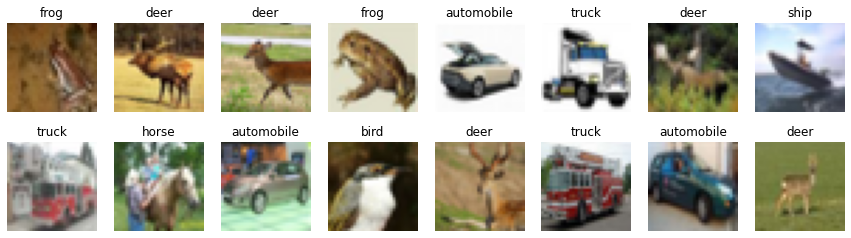

In [ ]:
# show some random images from train, and their labels

cols = 8
rows = 2
fig = plt.figure(figsize=(2 * cols - 1, 2.5 * rows - 1))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, len(y_train))
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid('off')
        ax.axis('off')
        ax.imshow(x_train[random_index, :])
        ax.set_title(cifar10_classes[y_train[random_index]])
plt.show()

In [ ]:
# normalize inputs
# convert class labels to one-hot encoded, should have shape (?, NUM_CLASSES)
x_train = x_train.astype(np.float64) - 0.5

y_train = keras.utils.to_categorical(y_train, num_classes=10)

y_val = keras.utils.to_categorical(y_val, num_classes=10)

y_test = keras.utils.to_categorical(y_test, num_classes=10)

In [ ]:
# import necessary building blocks
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout
#from keras.layers.advanced_activations import LeakyReLU

In [ ]:
from tensorflow.keras import layers

In [ ]:
from tensorflow.keras import callbacks

In [ ]:
input_shape=[32, 32, 3] # define the input shape


In [ ]:
    # Report of the results:
    # The optimal number of the blocks in the base turned out to be 3, sicne this number of blocks produced the higher accuracy
    # every time I experimented with the structure of CNN. Even when I increased the number of block by one the model started to overfit, since 
    # accuracy was increasing while validation accuracy was becoming lower.
    # I started training with a small number of epoches - 20 epoches,then increased it to 30 epoches. This number of epoches was obviously not 
    # enough for the network to learn, so the accuracy was low (around 0.49).
    # Then I increased the number of epoches to 200 but it was more then enough for the model to train, so the best strategy for me was
    # to call Early Stopping Callback which halts training when the model is not imporving anymore.
    # Any change of the batch_size would cause the decrease in accuracy, so I used the batch_size=32 for the next attempts. 
    # Adding Batch_Normalization() layers before each convolution block had a positve effect on the prediction accuracy, while
    # integrating Batch_Normaliztion() into the head of the model resulted in lower accuracy. 
    # I tried experimenting with "filter" parameter in Conv2D() layer. Setting the filter parameter to 32 in the first convolution block, 
    # to 64 in the second block and to 128 in the third block did not result in improvement. Increasing the number from 32 to 64 or to 128 in every 
    # convolution block did not result in the increase of accuracy either.
    # Changing the pool_size parameter to (2,2) or to (3,3) in the layers.MaxPool2D() deacresed the accuracy of the model. Increasing the kernel_size
    # in Conv2D() layer also had a negative effect.
    # I applied different augmentation layers configuring them before the base of CNN, however some of them: RandomRotation(), RandomConstrast(), 
    # RandomHeight(), RandomWidth(), RandomCrop() produced error. Only RandomFlip('horizontal') and GaussianNoise layer() (I put this layer in
    # various parts of network) worked properly, though the accuracy was becoming lower when they were used.



    

def make_model():
  # Ideas for the model's architercute were taken from this source: https://www.kaggle.com/code/ryanholbrook/custom-convnets
  
  model = Sequential([
      
#  Convolution layers filter an image for a particular feature (https://www.kaggle.com/code/ryanholbrook/convolution-and-relu)
#  Pooling layers condense an image to enhance the feautures (https://www.kaggle.com/code/ryanholbrook/convolution-and-relu)
# 'BatchNormalization' normilizes the input (https://www.kaggle.com/code/ryanholbrook/dropout-and-batch-normalization)
# 'Flatten' layer converts data into 1-dimentional array in order to supply it to the next layer
# 'Dropout' layer  randomly 'turns off' some of the layer's inputs in order to prevent model from learning spurious patterns  (https://www.kaggle.com/code/ryanholbrook/dropout-and-batch-normalization)
  

# Augment the images
  #layers.RandomFlip('horizontal'), # Horizontaly flip the images
  

# Base of the model (feature extactor)
    
  # Block One
  layers.BatchNormalization(renorm=True),
  layers.Conv2D(filters=32, kernel_size=3, activation='relu', padding='same', input_shape=input_shape),
  layers.Conv2D(filters=32, kernel_size=3, activation='relu', padding='same'),
  layers.MaxPool2D(),

  # Block Two
  layers.BatchNormalization(renorm=True),
  layers.Conv2D(filters=32, kernel_size=3, activation='relu', padding='same'),
  layers.Conv2D(filters=32, kernel_size=3, activation='relu', padding='same'),
  layers.MaxPool2D(),
   
  # Block Three
  layers.BatchNormalization(renorm=True),
  layers.Conv2D(filters=32, kernel_size=3, activation='relu', padding='same'),
  layers.Conv2D(filters=32, kernel_size=3, activation='relu', padding='same'),
  layers.MaxPool2D(),


# Head of the model (classifier)
    
  layers.Flatten(), 
  layers.Dense(6, activation='relu'),
  layers.Dropout(0.2),
  layers.Dense(10, activation='softmax'),  # 'softmax' activation function converts a vector of N real numbers into a vector storing probabilities 
  ])

  return model

In [ ]:
# Add an Early Stopping callback to stop the training when model stops improving 
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    min_delta=0.001, # Minimum change in the monitored quantity to qualify as an improvement. (https://keras.io/api/callbacks/early_stopping/)
    patience=10, # Number of epochs with no improvement after which training will be stopped. (https://keras.io/api/callbacks/early_stopping/)
    restore_best_weights=True,
)

In [ ]:
### STUDENT CODE HERE ###
### --> change the parameters below to perform a better training

INIT_LR = 5e-3  # initial learning rate
BATCH_SIZE = 32
EPOCHS = 200


K.clear_session()  # clear default graph
# don't call K.set_learning_phase() !!! (otherwise will enable dropout in train/test simultaneously)
model = make_model()  # define our model

# prepare model for fitting (loss, optimizer, etc)
model.compile(
    loss='categorical_crossentropy',  # we train 10-way classification
    optimizer=keras.optimizers.Adamax(learning_rate=INIT_LR),  # for SGD.
    metrics=['accuracy']  # report accuracy during training
)

# fit model
model.fit(
    x_train, y_train,  # prepared data
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stopping],
    validation_data=(x_val, y_val),
    shuffle=True,
)

# save weights to file to avoid re-training
model.save_weights("weights.h5")

Epoch 1/200
1250/1250 [==============================] - 25s 10ms/step - loss: 2.1774 - accuracy: 0.1596 - val_loss: 1.9964 - val_accuracy: 0.2221
Epoch 2/200
1250/1250 [==============================] - 11s 8ms/step - loss: 2.0174 - accuracy: 0.1913 - val_loss: 2.2558 - val_accuracy: 0.1408
Epoch 3/200
1250/1250 [==============================] - 14s 11ms/step - loss: 1.8504 - accuracy: 0.2673 - val_loss: 2.1993 - val_accuracy: 0.2162
Epoch 4/200
1250/1250 [==============================] - 15s 12ms/step - loss: 1.7535 - accuracy: 0.3166 - val_loss: 1.9641 - val_accuracy: 0.2959
Epoch 5/200
1250/1250 [==============================] - 11s 9ms/step - loss: 1.6309 - accuracy: 0.3583 - val_loss: 1.9517 - val_accuracy: 0.2990
Epoch 6/200
1250/1250 [==============================] - 11s 9ms/step - loss: 1.5717 - accuracy: 0.3780 - val_loss: 2.3837 - val_accuracy: 0.2682
Epoch 7/200
1250/1250 [==============================] - 12s 10ms/step - loss: 1.5208 - accuracy: 0.4064 - val_loss: 1.64

In [ ]:
6# load weights from file (can call without model.fit)
model.load_weights("weights.h5")

313/313 [==============================] - 1s 3ms/step


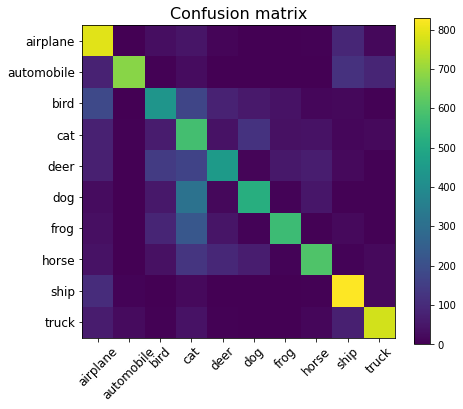

Test accuracy: 0.6232


In [ ]:
# make test predictions
y_pred_test = model.predict(x_test)
y_pred_test_classes = np.argmax(y_pred_test, axis=1)
y_pred_test_max_probas = np.max(y_pred_test, axis=1)
y_test_index = [list(onehot).index(1) for onehot in y_test]

# confusion matrix and accuracy
from sklearn.metrics import confusion_matrix, accuracy_score
plt.figure(figsize=(7, 6))
plt.title('Confusion matrix', fontsize=16)
plt.imshow(confusion_matrix(y_test_index, y_pred_test_classes))
plt.xticks(np.arange(10), cifar10_classes, rotation=45, fontsize=12)
plt.yticks(np.arange(10), cifar10_classes, fontsize=12)
plt.colorbar()
plt.show()
print("Test accuracy:", accuracy_score(y_test_index, y_pred_test_classes))

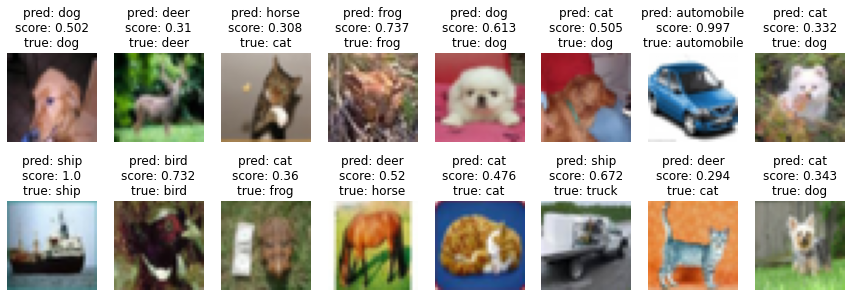

In [ ]:
# inspect preditions
cols = 8
rows = 2
fig = plt.figure(figsize=(2 * cols - 1, 3 * rows - 1))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, len(y_test))
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid('off')
        ax.axis('off')
        ax.imshow(x_test[random_index, :])
        pred_label = cifar10_classes[y_pred_test_classes[random_index]]
        pred_proba = y_pred_test_max_probas[random_index]
        true_label = cifar10_classes[y_test_index[random_index]]
        ax.set_title("pred: {}\nscore: {:.3}\ntrue: {}".format(
               pred_label, pred_proba, true_label
        ))
plt.show()

# Some tips on how to improve:

* The ultimate quest is to create a network that has as high __accuracy__ as you can push it.

## Potential grading:
* starting at zero points
* +2 for describing your iteration path in a report below.
* +2 for building a network that gets above 20% accuracy
* +1 for beating each of these milestones on __TEST__ dataset:
    * 50% (5 total)
    * 60% (6 total)
    * 65% (7 total)
    * 70% (8 total)
    * 75% (9 total)
    * 80% (10 total)

## Bonus points
Common ways to get bonus points are:
* Get higher score, obviously.
* Anything special about your NN. For example \"A super-small/fast NN that gets 80%\" gets a bonus.
* Any detailed analysis of the results. (saliency maps, whatever)


## Tips on what can be done:

 * __Network size__
   * More neurons, 
   * More layers, ([lasagne docs](http://lasagne.readthedocs.org))
   * Nonlinearities in the hidden layers
   * tanh, relu, leaky relu, etc
   * Larger networks may take more epochs to train, so don't discard your net just because it could didn't beat the baseline in 5 epochs.

 * __Convolution layers__
   * they __are a must__ unless you have any super-ideas
   * `network = lasagne.layers.Conv2DLayer(prev_layer,`
     `                       num_filters = n_neurons,`
     `                       filter_size = (filter width, filter height),`
     `                       nonlinearity = some_nonlinearity)`
   * Warning! Training convolutional networks can take long without GPU. That's okay.
     * If you are CPU-only, we still recomment to try a simple convolutional architecture
     * a perfect option is if you can set it up to run at nighttime and check it up at the morning.
     * Make reasonable layer size estimates. A 128-neuron first convolution is likely an overkill.
     * __To reduce computation__ time by a factor in exchange for some accuracy drop, try using __stride__ parameter. A stride=2 convolution should take roughly 1/4 of the default (stride=1) one.

   * Plenty other layers and architectures
     * http://lasagne.readthedocs.org/en/latest/modules/layers.html
     * batch normalization, pooling, etc


 * __Early Stopping__
   * Training for 100 epochs regardless of anything is probably a bad idea.
   * Some networks converge over 5 epochs, others - over 500.
   * Way to go: stop when validation score is 10 iterations past maximum


 * __Faster optimization__ - 
   * rmsprop, nesterov_momentum, adam, adagrad and so on.
     * Converge faster and sometimes reach better optima
     * It might make sense to tweak learning rate/momentum, other learning parameters, batch size and number of epochs
   * __BatchNormalization__ (lasagne.layers.batch_norm) FTW!


 * __Regularize__ to prevent overfitting
   * Add some L2 weight norm to the loss function, theano will do the rest
     * Can be done manually or via - http://lasagne.readthedocs.org/en/latest/modules/regularization.html
   * Dropout - to prevent overfitting
     * `lasagne.layers.DropoutLayer(prev_layer, p=probability_to_zero_out)`   
     * Don't overdo it. Check if it actually makes your network better


 * __Data augmentation__ - getting 5x as large dataset for free is a great deal
   * Zoom-in+slice = move
   * Rotate+zoom(to remove black stripes)
   * any other perturbations
   * Add Noize (easiest: GaussianNoizeLayer)
   * Simple way to do that (if you have PIL/Image): 
     * ```from scipy.misc import imrotate,imresize```
     * and a few slicing
   * Stay realistic. There's usually no point in flipping dogs upside down as that is not the way you usually see them.


